In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import zarr
import numpy as np
import sys
import glob
import pandas as pd
import os
import time
import cartopy.crs as ccrs
import geopandas as gpd
import rioxarray
import geopandas
import matplotlib
import matplotlib.pyplot as plt


In [10]:
def data_path(filename):
    file_path = "{path}/{filename}".format(
        path="/Users/wantongli/Documents/GitHub/Syndrome-of-change",
        filename=filename
    )
    return file_path


def read_data(path):
    data = np.load(path)
    return data

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def graph(target, ax, min, max, title):
    ax.coastlines(linewidth=0.1)
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    lon = np.arange(-180, 180, 0.25)
    lat = np.arange(-90, 90, 0.25)
    if max > 0 and min < 0:
        norm = matplotlib.colors.TwoSlopeNorm(vmin=min, vcenter=0, vmax=max)
        cmap = 'coolwarm'
    elif max <= 0:
        norm = matplotlib.colors.Normalize(vmin=min, vmax=max)
        cmap = truncate_colormap(plt.get_cmap('coolwarm'), 0, 0.5)
    elif min >= 0:
        norm = matplotlib.colors.Normalize(vmin=min, vmax=max)
        cmap = truncate_colormap(plt.get_cmap('coolwarm'), 0.5, 1)

    map = ax.pcolormesh(lon, lat, target, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    cbar = ax.figure.colorbar(map, ax=ax, ticks=[min, max], shrink=0.4, extend='both')
    plt.title(title)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    return (cbar)

In [ ]:
# read multi-stream data by downloading them from public links
# for example, read incoming shortwave radiation
ssrd = xr.open_mfdataset(".../ssrd.*.nc").ssrd[:,::-1,:]
ssrd_1d = ssrd.resample(time='1D').ffill().sel(time=slice('2003-01-05','2022-12-26'))
ssrd_8d = ssrd_1d.resample(time='8D').ffill() # resample data to 8 daily, as a large set of data support such temporal resolution


#### create a new datacube
time = pd.date_range('2003-01-05', freq='8D', periods=912)
lat = ssrd.lat
lon = ssrd.lon

new_datacube = xr.Dataset(
    data_vars=dict(
        ssrd=(["time", "lat", "lon"], ssrd_8d.values),
        # add more variables
    ),
    coords=dict(
        time=time,
        lat=lat,
        lon=lon,
    ),
    attrs=dict(description="Datacube"),
)

# new_datacube.to_zarr(data_path('data/New_datacube_Jan13_example.zarr'))



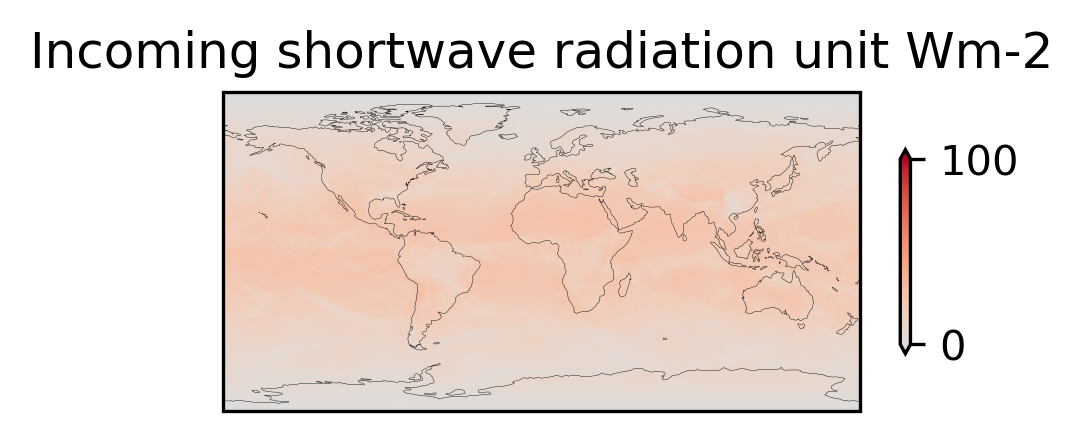

In [13]:
## plot the data using plt.pcolormesh to check every single dataset has the same order of lat and lon
ds1 = xr.open_zarr(data_path('data/New_datacube_Jan.zarr'))
ds2 = xr.open_zarr(data_path('data/New_datacube_Jan13.zarr'))
ds_2003_2022 = xr.merge([ds1, ds2])

fig = plt.figure(figsize=(3, 2), dpi=300, tight_layout=True)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
graph(ds_2003_2022.ssrd[100,:,:], ax, 0,100, 'Incoming shortwave radiation unit Wm-2') # select a time step
plt.show()